In [1]:
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance

# Модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# Настройки для честного эксперимента
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Пути к артефактам
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
DATASET_PATH = "S06-hw-dataset-02.csv"

# Создаем папки
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv(DATASET_PATH)

# Удаляем ID, так как это не признак
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print(f"Размер датасета: {df.shape}")
print("\n--- Баланс классов (Target) ---")
print(df['target'].value_counts(normalize=True))

# Разделяем на признаки (X) и таргет (y)
X = df.drop(columns=['target'])
y = df['target']

Размер датасета: (18000, 38)

--- Баланс классов (Target) ---
target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


In [ ]:
# Фиксированный random_state и stratify для честного сравнения
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Кросс-валидация для подбора параметров (только на Train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Train shape: (13500, 37), Test shape: (4500, 37)


In [ ]:
results = []
search_summaries = {}  # Сохраняем лучшие параметры

def evaluate_model(model, name, X_test, y_test, grid_search=None):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    print(f"[{name}] Accuracy: {metrics['accuracy']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    
    # Сохраняем параметры если был поиск
    if grid_search is not None:
        search_summaries[name] = {
            "best_params": grid_search.best_params_,
            "best_cv_score": grid_search.best_score_
        }
        
    metrics['model_obj'] = model
    return metrics

In [5]:
# 1. Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
results.append(evaluate_model(dummy, "Dummy", X_test, y_test))

# 2. Logistic Regression
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(random_state=RANDOM_STATE))])
pipe_lr.fit(X_train, y_train)
results.append(evaluate_model(pipe_lr, "LogisticRegression", X_test, y_test))

[Dummy] Accuracy: 0.7373 | ROC-AUC: 0.5000
[LogisticRegression] Accuracy: 0.8162 | ROC-AUC: 0.8009


In [ ]:
dt_params = {"max_depth": [3, 5, 10, None], "min_samples_leaf": [1, 5, 20]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), dt_params, cv=cv, scoring="roc_auc", n_jobs=1)
dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
results.append(evaluate_model(best_dt, "DecisionTree", X_test, y_test, grid_search=dt_grid))

[DecisionTree] Accuracy: 0.8322 | ROC-AUC: 0.8397


In [ ]:
rf_params = {"n_estimators": [100, 200], "max_depth": [5, 10, None], "max_features": ["sqrt", 0.5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1), rf_params, cv=cv, scoring="roc_auc", n_jobs=1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
results.append(evaluate_model(best_rf, "RandomForest", X_test, y_test, grid_search=rf_grid))

[RandomForest] Accuracy: 0.8924 | ROC-AUC: 0.9291


In [ ]:
# Облегченная версия для Бустинга 
gb_params = {
    "n_estimators": [50],       
    "learning_rate": [0.1],     
    "max_depth": [3]            
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE), 
    gb_params, 
    cv=3, 
    scoring="roc_auc", 
    n_jobs=1 
)
gb_grid.fit(X_train, y_train)

print(f"Лучшие параметры бустинга: {gb_grid.best_params_}")
best_gb = gb_grid.best_estimator_
results.append(evaluate_model(best_gb, "GradientBoosting", X_test, y_test, grid_search=gb_grid))

Лучшие параметры бустинга: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
[GradientBoosting] Accuracy: 0.8447 | ROC-AUC: 0.8800


In [16]:
# Стекинг (объединяем модели)
estimators = [('dt', best_dt), ('rf', best_rf), ('gb', best_gb)]

# n_jobs=1 чтобы не было конфликта
stacking = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(), 
    cv=3, 
    n_jobs=1
)
stacking.fit(X_train, y_train)

results.append(evaluate_model(stacking, "Stacking", X_test, y_test))

[Stacking] Accuracy: 0.9147 | ROC-AUC: 0.9318


,model,accuracy,f1,roc_auc
9,Stacking,0.914667,0.826871,0.931782
3,RandomForest,0.892444,0.759682,0.929133
6,RandomForest,0.892444,0.759682,0.929133
7,RandomForest,0.892444,0.759682,0.929133
4,GradientBoosting,0.904222,0.800924,0.926689
8,GradientBoosting,0.844667,0.622366,0.880016
2,DecisionTree,0.832222,0.653511,0.839702
5,DecisionTree,0.832222,0.653511,0.839702
1,LogisticRegression,0.816222,0.571724,0.800890
0,Dummy,0.737333,0.000000,0.500000


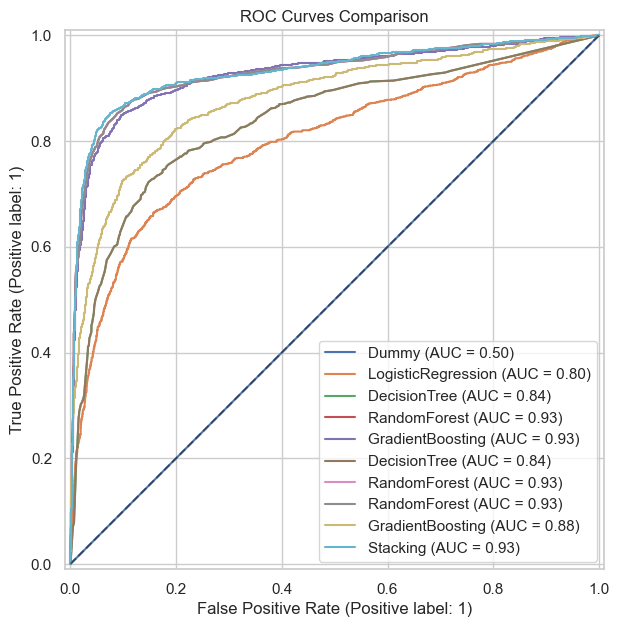

In [17]:
# Таблица
df_results = pd.DataFrame(results).drop(columns=['model_obj']).sort_values("roc_auc", ascending=False)
display(df_results)

# ROC кривая
plt.figure(figsize=(10, 7))
for res in results:
    model = res['model_obj']
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=res['model'], ax=plt.gca())

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.title("ROC Curves Comparison")
plt.savefig(FIGURES_DIR / "roc_curves.png")
plt.show()

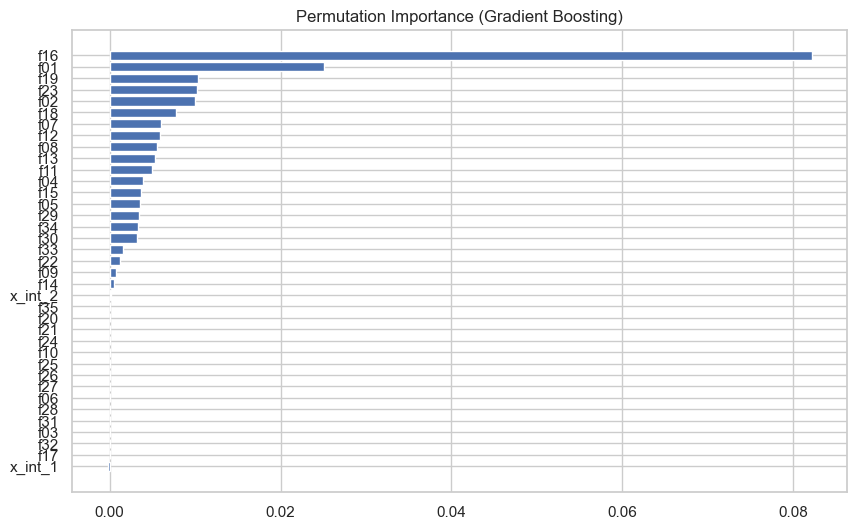

In [18]:
best_model = best_gb # Берем бустинг как одну из лучших моделей
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (Gradient Boosting)")
plt.savefig(FIGURES_DIR / "feature_importance.png")
plt.show()

In [ ]:
import json
import joblib

# Удаляем дубликаты, если ячейки запускались несколько раз
# keep='last' оставит самый свежий результат
df_results = df_results.drop_duplicates(subset=['model'], keep='last')

# 1. Метрики на тесте
metrics_dict = df_results.set_index('model').to_dict(orient='index')
with open(ARTIFACTS_DIR / "metrics_test.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)

# 2. Параметры CV
with open(ARTIFACTS_DIR / "search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)

# 3. Лучшая модель
# Сохраняем ту модель, которая победила по метрикам
best_model_name = df_results.iloc[0]['model']
# Нам нужно найти объект модели в results по имени
best_model_obj = next(r['model_obj'] for r in results if r['model'] == best_model_name)

joblib.dump(best_model_obj, ARTIFACTS_DIR / "best_model.joblib")

# 4. Метаданные
best_meta = {
    "best_model": best_model_name,
    "params": search_summaries.get(best_model_name, {}).get("best_params", "Default/No Search"),
    "metrics": metrics_dict[best_model_name]
}
with open(ARTIFACTS_DIR / "best_model_meta.json", "w") as f:
    json.dump(best_meta, f, indent=4)

print("Все артефакты (json, joblib, png) успешно сохранены!")

Все артефакты (json, joblib, png) успешно сохранены!
